<div style="text-align:center"><span style="color:black; font-family:Times New Roman; font-size:3em;"> Next-day stock prediction </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Introduction </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;padding-left:3em;padding-right:3em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Stock market prediction is both an interesting and challenging task by researchers and investors because of its dynamic and seemly chaotic nature. Stock analysis is challenging because there are so many data and diverse parameters that decide the stock price and it also involves the profit risk in the markets.  Many techniques have been applied to stock market prediction such as  statistical analysis. Recently, many researchers have turned to techniques in the field of Machine learning for forecasting stock price. Machine learning algorithms has the ability to learn from given past massive data and predict future data movement.

<br \>
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this project, I utilized several Machine Learning techniques to predict whether tomorrow’s exchange closing price is lower or higher than today's price. There are two types of analysis for machine learning techniques: Fundamental Analysis and Technical Analysis. Fundamental analysis is focused on statistical data of a company, such as financial status of the company. Technical Analysis uses quantitative parameters like daily volume, open, close, highest, lowest prices and volume of a stock. It also includes simple Moving Average (EMA) of last n days and Exponential Moving Average (EMA) which applies more weight on price of recent days. When applying Machine Learning to stock data, I used a hybrid analysis model involving both Fundamental and Technical Analysis. After collecting all related input variables, I applied Principal components analysis (PCA) to filter out unrelated variables. Several Machine Learning models were applied on selected variables filtered by the PCA in order to achieve best accuracy performance of next-day stock prediction.
 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Data Collection and Processing </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The stock market data used in this project was collected from Quandl. The equity fundamental data of a company was implemented from the Sharadar Core Fundamentals database, SF1. This database covers over 200 essential financial ratios and fundamental indicators for nearly 3000 US companies, with quarterly and annual reporting periods. The financial indicators of a company were download quarterly from SF1, such as total assets, revenue, capital expenditure, shareholders equity, Gross profit, etc. I also used the Wiki EOD database to extract daily adjusted open, high, low, close stock price and volume data. Stockstats module in Python was used to calculate other stock market indicators, including relative strength index and stochastic oscillator.
 </span></div>

In [93]:
import quandl
import pandas as pd
import numpy as np
from stockstats import StockDataFrame
import warnings
warnings.filterwarnings("ignore")

def SF1_List (company_ticker):    
        sqllist=['SF1/{}_ASSETS_ARQ'.format(company_ticker),    # Total Assets                           
             'SF1/{}_REVENUE_ARQ'.format(company_ticker),       # Revenue                                     
             'SF1/{}_CAPEX_ARQ'.format(company_ticker),         # Capital Expenditure                     
             'SF1/{}_EQUITY_ARQ'.format(company_ticker),        # Shareholders Equity                     
             'SF1/{}_GP_ARQ'.format(company_ticker),            # Gross Profit                               
             'SF1/{}_EPS_ARQ'.format(company_ticker),           # Earnings per Basic Share         
             'SF1/{}_EBIT_ARQ'.format(company_ticker),          # Earning Before Interest & Taxes (EBIT)
             'SF1/{}_EBITDA_ARQ'.format(company_ticker),        # Earnings Before Interest, Taxes and Depreciation Amortization             
             'SF1/{}_NCFO_ARQ'.format(company_ticker),          # Net Cash Flow from Operations  
             'SF1/{}_LIABILITIES_ARQ'.format(company_ticker),   # Total Liabilities
             'SF1/{}_PB_ARQ'.format(company_ticker),            # Price to Book Value (Price to book value (P/B) ratio)
             'SF1/{}_SHARESWA_ARQ'.format(company_ticker),      # Shares Outstanding (Weighted Average Shares)  
             'SF1/{}_LIABILITIESC_ARQ'.format(company_ticker),  # Current Liabilities
             'SF1/{}_ASSETSC_ARQ'.format(company_ticker),       # Current Assets
             'SF1/{}_INVENTORY_ARQ'.format(company_ticker),     # Inventory 
             'SF1/{}_CURRENTRATIO_ARQ'.format(company_ticker),  # Current Ratio #Current Assets/Current Liabilities
             'SF1/{}_DE_ARQ'.format(company_ticker),            # Debt to Equity Ratio #Total Liabilities/ Shareholders Equity
             'SF1/{}_BVPS_ARQ'.format(company_ticker),          # Book Value per Share #(Stockholders' Equity - Preferred Stock)/ Average shares outstanding                      
             'SF1/{}_NETINC_ARQ'.format(company_ticker),         # Net Income
            ]   
        return sqllist

#######################################################################################################
def get_fundamantal_data(ticker, date):
    import quandl
    import pandas as pd
    from stockstats import StockDataFrame
    import warnings
    warnings.filterwarnings("ignore")
    
    quandl.ApiConfig.api_key = 'LqAzd9wm8ZWXxLDNtc_1'
    fundamental_data=quandl.get(SF1_List(ticker),start_date= date)
    new_columnnames=['Total Assets','REVENUE','Capital Expenditure','Shareholders Equity','Gross Profit',
                'Earnings per Basic Share','Earning Before Interest and Taxes','EBITDA',
                'Net Cash Flow from Operation','Total Liabilities',
                'Price to Book Value', 'Shares Outstanding',
                'Current Liabilities','Current Assets','Inventory',
                'Current Ratio','Debt to Equity Ratio','Book Value per Share','Net Income']
    old_columnnames=list(fundamental_data.columns)
    fundamental_data.rename(columns=dict(zip(old_columnnames,new_columnnames)),inplace=True)
    fundamental_data.columns=fundamental_data.columns.map(str.title)
    return fundamental_data

#######################################################################################################
def get_technical_data(ticker,fundamental_data):
    data=quandl.get(ticker, start_date= fundamental_data.index[0])
    selectedcol=["Adj. Close",'Adj. Open','Adj. High','Adj. Low', 'Adj. Volume']
    technical_data=data[selectedcol]

    technical_data['5-days moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 5, min_periods=2)
    technical_data['1-week Ewma'] = pd.ewma(technical_data['Adj. Close'], span=5, min_periods=2)
    technical_data['1-week annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 5) * (255**0.5)
    technical_data['2-day price change'] = technical_data['Adj. Close'].diff()
    
    stock = StockDataFrame.retype(data)
    #RSI is considered overbought when above 70 and oversold when below 30
    technical_data['2-days relative strength index']= stock['rsi_2']
    technical_data['1-week relative strength index']= stock['rsi_5']
    technical_data['stochastic oscillator K line']= stock['kdjk']
    technical_data['stochastic oscillator J line']= stock['kdjj']

    return technical_data

#######################################################################################################
def get_hybrid_data(technical_data, fundamental_data):
    combined_data=pd.concat([technical_data,fundamental_data], axis=1).fillna(method= 'ffill')
    combined_data.dropna(inplace=True)
                   
    combined_data["PE Ratio"]= combined_data['Adj. Close'] / combined_data['Earnings Per Basic Share'] 
    combined_data['Capital Expenditure Coverage'] = combined_data['Net Cash Flow From Operation'] / combined_data['Capital Expenditure']

    combined_data['Free Cash Flow Operating Ratio'] = \
    (combined_data["Net Cash Flow From Operation"] - combined_data["Capital Expenditure"]) / combined_data["Net Cash Flow From Operation"]
    combined_data['Operating Cash Flow Ratio'] = combined_data["Net Cash Flow From Operation"] / combined_data["Revenue"] 
    combined_data['Debt Ratio'] = combined_data["Total Liabilities"] / combined_data["Total Assets"] 
    combined_data['Cash Flow To Debt Ratio'] = combined_data["Net Cash Flow From Operation"] / combined_data["Total Liabilities"] 
    combined_data['Cash Flow Per Share'] = combined_data["Net Cash Flow From Operation"] / combined_data["Shares Outstanding"]
    combined_data['Cash Ratio']  = combined_data["Net Cash Flow From Operation"] / combined_data["Current Liabilities"]
    combined_data['Quick Ratio'] = (combined_data["Current Assets"] - combined_data["Inventory"]) / combined_data["Current Liabilities"]
    combined_data['Gross Profit Margin'] = combined_data["Gross Profit"] / combined_data["Revenue"]
    combined_data['Price To Sales Ratio'] = combined_data['Adj. Close'] / (combined_data["Revenue"] / combined_data["Shares Outstanding"] )
    combined_data['Return On Average Equity']  = combined_data["Net Income"] / combined_data["Shareholders Equity"] 
    return combined_data


<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   For illustration purpose, I chose the Apple stock data, starting from 2010-02-01 until the most recent date (2017-04-07). There are 44 features as the input variables which are 13 technical and 31 fundamental features.   

 </span></div>

In [2]:
# Import the fundamental data of the AAPL stock
fundamental_data = get_fundamantal_data('AAPL', '2010-02-01')
# Import the technical data of the AAPL stock, and combined them with the fundamental data into one dataframe
technical_data = get_technical_data('WIKI/AAPL',fundamental_data)
combined_data = get_hybrid_data(technical_data, fundamental_data)
#combined_data.to_csv('stockdata.csv')

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  Technical input variables </span></div>

In [65]:
list(combined_data.columns)[:13]

[u'Adj. Close',
 u'Adj. Open',
 u'Adj. High',
 u'Adj. Low',
 u'Adj. Volume',
 '5-days moving average',
 '1-week Ewma',
 '1-week annualized historical volatility',
 '2-day price change',
 '2-days relative strength index',
 '1-week relative strength index',
 'stochastic oscillator K line',
 'stochastic oscillator J line']

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;"> Fundamental input variables </span></div>

In [64]:
list(combined_data.columns)[13:]

['Total Assets',
 'Revenue',
 'Capital Expenditure',
 'Shareholders Equity',
 'Gross Profit',
 'Earnings Per Basic Share',
 'Earning Before Interest And Taxes',
 'Ebitda',
 'Net Cash Flow From Operation',
 'Total Liabilities',
 'Price To Book Value',
 'Shares Outstanding',
 'Current Liabilities',
 'Current Assets',
 'Inventory',
 'Current Ratio',
 'Debt To Equity Ratio',
 'Book Value Per Share',
 'Net Income',
 'PE Ratio',
 'Capital Expenditure Coverage',
 'Free Cash Flow Operating Ratio',
 'Operating Cash Flow Ratio',
 'Debt Ratio',
 'Cash Flow To Debt Ratio',
 'Cash Flow Per Share',
 'Cash Ratio',
 'Quick Ratio',
 'Gross Profit Margin',
 'Price To Sales Ratio',
 'Return On Average Equity']

In [94]:
combined_data = pd.read_csv('stockdata.csv',index_col=0)

In [100]:
combined_data.head()

,Adj. Close,Adj. Open,Adj. High,Adj. Low,Adj. Volume,5-days moving average,1-week Ewma,1-week annualized historical volatility,2-day price change,2-days relative strength index,...,Free Cash Flow Operating Ratio,Operating Cash Flow Ratio,Debt Ratio,Cash Flow To Debt Ratio,Cash Flow Per Share,Cash Ratio,Quick Ratio,Gross Profit Margin,Price To Sales Ratio,Return On Average Equity
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,25.229885,24.924115,25.394430,24.785482,187469100.0,25.910274,25.583044,0.450414,0.345546,34.900471,...,1.065041,0.368616,0.336721,0.318372,0.914022,0.441399,2.501031,0.408787,10.174955,0.094442
2010-02-02,25.376291,25.382770,25.435891,25.054974,174585600.0,25.649074,25.509842,0.427720,0.146407,48.141773,...,1.065041,0.368616,0.336721,0.318372,0.914022,0.441399,2.501031,0.408787,10.234000,0.094442
2010-02-03,25.812920,25.286893,25.938597,25.189720,153832000.0,25.424826,25.614970,0.452734,0.436629,76.568723,...,1.065041,0.368616,0.336721,0.318372,0.914022,0.441399,2.501031,0.408787,10.410088,0.094442
2010-02-04,24.882655,25.489012,25.701496,24.820464,189413000.0,25.237218,25.364346,0.428907,-0.930265,22.953576,...,1.065041,0.368616,0.336721,0.318372,0.914022,0.441399,2.501031,0.408787,10.034921,0.094442
2010-02-05,25.324466,24.957154,25.394430,24.727179,212576700.0,25.325243,25.350818,0.363032,0.441811,53.729037,...,1.065041,0.368616,0.336721,0.318372,0.914022,0.441399,2.501031,0.408787,10.213099,0.094442


<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  The technical and fundamental variables in the combined_data dataframe are chosen to be the feature variables X, which will be used to train a specific Machine Learning model. The predicted output Y is whether the adjusted closing price on the next day is higher or lower than the current day's price.
Therefore, I shifted the 'Adj. Close' (Adjusted closing price) column of the combined_data dataframe backwards one day and substrate it by the 'Adj. Close' value on the current day.
The target variable Y is set to be the difference between the adjusted closing price of the current day and next day.
If the difference is larger than 0, I label it as 1, which means the closing price on the next day is higher than the current day.
Otherwise, I label it as 0.
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Because the target variable is the closing price on the day t+1 subtracted by the price on the day t, the last day in the target variable will be ‘NULL’. Therefore I drop the data on the last day in both the feature variables and target variable.

 </span></div>

In [97]:
def generate_XY_variables(combined_data):
    X=combined_data[:-1]
    Y_class= combined_data['Adj. Close'].shift(-1) - combined_data['Adj. Close']
    Y_class=Y_class[:-1]
    Y = Y_class > 0
    return X, Y

In [98]:
X, Y = generate_XY_variables(combined_data)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
I split my dataset into the training and test sets by selecting a split date. 
Train-Test split still maintained temporal order of data observations. I didn’t shuffle data randomly, because I may lose its nature order of data. Therefore, I used the feature variables X and the target variable Y since 2010-02-01 to 2016-10-13 as the training set and the last 120 days (2016-10-14 ~ 2017-04-07 ) as the test set for model evaluation, which I call them as x_train, x_test, y_train, y_test.
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Data normalization procedure before data modeling is quite essential to enhance the learning capability of most Machine Leaning models with minimum error and improve the prediction accuracy. 
There are many types of data normalization. It can be used to scale the data in the similar range of values for each feature variable in order to minimize bias between features. 
I use the median method to normalize each feature column by the median of the feature values for all the samples. Median is very useful because it is not influenced by the magnitude of extreme outliers.       


 </span></div>

In [102]:
def split_scale (X,Y):
    #from sklearn.model_selection import train_test_split
    #x_train,x_test, y_train,y_test=train_test_split(X,Y, test_size=0.2, random_state=0)
    #x_train=x_train.sort_index()
    #y_train=y_train.sort_index()
    #y_test=y_test.sort_index()
    
    #x_train = X[:int(len(X)*.8)]
    #y_train = Y[:int(len(X)*.8)]
    #x_test = X[int(len(X)*.8):]
    #y_test = Y[int(len(X)*.8):]
    
    x_train = X[:-120]
    y_train = Y[:-120]
    x_test = X[-120:]
    y_test = Y[-120:]

    x_train_scaled=x_train.apply(lambda x: x / np.median(x))
    x_test_scaled=x_test/x_train.median()
    return x_train_scaled, x_test_scaled, y_train, y_test, x_test

In [103]:
x_train_scaled, x_test_scaled, y_train, y_test, x_test = split_scale (X,Y)

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Feature /Model selection </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Principal components analysis (PCA) is very powerful for dimensionality reduction. Given a set of data on n dimensions, PCA tries to ﬁnd a linear subspace of dimension d lower than n such that most of the variability of the data information can be maintained. I try to evaluate the stock prediction accuracy generated by different Machine learning algorithms. For each learning algorithm (except for Neural network), I construct a pipeline to perform a PCA followed by prediction with a specific classifier. The use of GridSearchCV can find the best number of extracted features through PCA and the best hyperparameters of a model by optimizing the classification accuracy at the end of the pipeline. In the end, I will select the one that performed best as my best model for short-term stock prediction.  
    
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I split all data into the training set and test set in the previous section. 
By default, GridSearchCV uses 3-fold cross validation, which further divides the training data into the train set and validation set. 3-Fold Cross Validation will yield 3 different combination of train/validation sets. 
The train set is used to train the model and the validation set is for prediction error estimation. A model with best parameters will be selected by the validation set with maximum prediction accuracy and will be assessed by the test set to estimate generalization error of this selection.

 </span></div>

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #1 : Support Vector Classifier </span></div>

In [116]:
def model_SVC_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)
    classifier = SVC(random_state=0)
    C = np.logspace(-3,3,7)#'linear', 'poly',
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)])
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__C=C, clf__kernel=['linear', 'rbf']), 
                        scoring='accuracy', n_jobs=-1)
    grid.fit(x_train_scaled, y_train)
    for params, mean_score, scores in grid.grid_scores_: 
        print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)


In [109]:
accuracy_SVC = model_SVC_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

0.54115 +/- 0.02373 {'pca__n_components': 4, 'clf__C': 1, 'clf__kernel': 'linear'}
Best parameters set found on development set:{'pca__n_components': 4, 'clf__C': 1, 'clf__kernel': 'linear'}
Best average accuracy in validation set: 0.54115
Accuracy in test set: 0.54167


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #2 : Logistic Regression </span></div>

In [163]:
def model_Logis_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)
    classifier = LogisticRegression(random_state=0)# default: ‘l2’
    C = np.logspace(-3,3,7)
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__C=C, 
                                  clf__penalty =['l1','l2']), scoring='accuracy', n_jobs=-1)
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_: 
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [164]:
accuracy_Logis = model_Logis_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'clf__penalty': 'l2', 'clf__C': 0.01, 'pca__n_components': 1}
Best average accuracy in validation set: 0.52753
Accuracy in train set: 0.52398
Accuracy in test set: 0.55000


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #3 : SGD Classifier  </span></div>

In [165]:
def model_SGD_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)
    classifier = SGDClassifier(loss='log',random_state=0)# default: ‘l2’
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, 
                                  clf__alpha=np.logspace(-7,-1,7), 
                                  clf__penalty=['elasticnet', 'l1','l2'],
                                  clf__l1_ratio=np.linspace(0.1,0.9,9) 
                                 ), scoring='accuracy', n_jobs=-1)    
    grid.fit(x_train_scaled, y_train)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [112]:
accuracy_SGD = model_SGD_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'clf__penalty': 'elasticnet', 'clf__l1_ratio': 0.2, 'pca__n_components': 10, 'clf__alpha': 0.1}
Best average accuracy in validation set: 0.53108
Accuracy in test set: 0.54167


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #4 : Linear Discriminant Analysis </span></div>

In [167]:
def model_LDA_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)
    classifier =LinearDiscriminantAnalysis()
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components), scoring='accuracy', n_jobs=-1)   
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_:
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [168]:
accuracy_LDA = model_LDA_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'pca__n_components': 1}
Best average accuracy in validation set: 0.52635
Accuracy in test set: 0.55000


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #5 :  Quadratic Discriminant Analysis  </span></div>

In [169]:
def model_QDA_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)
    classifier = QuadraticDiscriminantAnalysis()
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components), scoring='accuracy', n_jobs=-1)   
    grid.fit(x_train_scaled, y_train)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [170]:
accuracy_LDA = model_QDA_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'pca__n_components': 2}
Best average accuracy in validation set: 0.52575
Accuracy in test set: 0.48333


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #6 :  GaussianNB </span></div>

In [171]:
def model_GaussianNB_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)    
    classifier = GaussianNB()
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components), scoring='accuracy', n_jobs=-1)   
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_:
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [172]:
accuracy_GaussianNB = model_GaussianNB_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'pca__n_components': 2}
Best average accuracy in validation set: 0.52694
Accuracy in test set: 0.52500


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #7 :  NuSVC </span></div>

In [86]:
def model_NuSVC_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)  
    classifier = NuSVC(random_state=0)
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, 
                                  clf__nu=[0.5,0.6,0.7,0.8,0.9,1],
                                  clf__kernel=['linear']) , 
                        scoring='accuracy', n_jobs=-1)    
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_: 
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [97]:
accuracy_NuSVC = model_NuSVC_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

0.53458 +/- 0.01518 {'pca__n_components': 5, 'clf__nu': 0.9, 'clf__kernel': 'linear'}
Best parameters set found on development set:{'pca__n_components': 5, 'clf__nu': 0.9, 'clf__kernel': 'linear'}
Best average accuracy in validation set: 0.53458
Accuracy in test set: 0.50829


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #8 :  Decision Tree Classifier </span></div>

In [173]:
def model_DecisionTree_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)     
    classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__max_depth=range(1,10),
                                 clf__max_features=np.linspace(0.1,1,10)) , 
                        scoring='accuracy', n_jobs=-1)
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_: 
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [174]:
accuracy_DecisionTree = model_DecisionTree_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'clf__max_features': 0.20000000000000001, 'clf__max_depth': 1, 'pca__n_components': 29}
Best average accuracy in validation set: 0.54174
Accuracy in test set: 0.50000


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #9 :  Random Forest Classifier </span></div>

In [8]:
def model_RandomForest_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)     
    classifier = RandomForestClassifier(criterion='entropy', random_state=0)
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__max_depth=range(1,10), 
                                  clf__n_estimators=range(1,20,2),
                                  clf__max_features=[0.1,0.2,0.4,0.6,0.8,1.0]
                                 ), scoring='accuracy', n_jobs=-1) 
    grid.fit(x_train_scaled, y_train)
    for params, mean_score, scores in grid.grid_scores_: 
        print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [76]:
accuracy_RandomForest = model_RandomForest_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

0.53404 +/- 0.00807 {'clf__max_features': 0.4, 'clf__max_depth': 1, 'pca__n_components': 7, 'clf__n_estimators': 100}
Best parameters set found on development set:{'clf__max_features': 0.4, 'clf__max_depth': 1, 'pca__n_components': 7, 'clf__n_estimators': 100}
Best average accuracy in validation set: 0.53404
Accuracy in test set: 0.54167


C:\Python27\Scripts\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #10  Extra Trees Classifier </span></div>

In [31]:
def model_ExtraTree_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)     
    classifier = ExtraTreesClassifier(criterion='entropy', random_state=0)#randomly select some features and threshold for each split
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__max_depth=range(1,10), 
                                  clf__n_estimators=[10,20,50,100,110,150,200,300,500]), 
                   scoring='accuracy', n_jobs=-1)   
    grid.fit(x_train_scaled, y_train)
    for params, mean_score, scores in grid.grid_scores_: 
        print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [82]:
accuracy_ExtraTree = model_ExtraTree_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

0.54589 +/- 0.01915 {'pca__n_components': 14, 'clf__max_depth': 1, 'clf__n_estimators': 110}
Best parameters set found on development set:{'pca__n_components': 14, 'clf__max_depth': 1, 'clf__n_estimators': 110}
Best average accuracy in validation set: 0.54589
Accuracy in test set: 0.54167


C:\Python27\Scripts\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #11  Bagging Classifier </span></div>

In [12]:
def model_Bagging_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)  
    tree=DecisionTreeClassifier(criterion='entropy',  max_depth=None)
    classifier = BaggingClassifier(base_estimator=tree, 
                               max_samples=5, bootstrap=True, bootstrap_features =True, random_state=0) 
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__n_estimators=range(1,40,5), 
                                  clf__max_samples=range(1,20,2)), scoring='accuracy', n_jobs=-1)    
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_: 
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [85]:
accuracy_Bagging = model_Bagging_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'pca__n_components': 35, 'clf__n_estimators': 200, 'clf__max_samples': 3}
Best average accuracy in validation set: 0.54944
Accuracy in test set: 0.54167


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #12  AdaBoost Classifier </span></div>

In [12]:
def model_AdaBoost_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)  
    tree=DecisionTreeClassifier(criterion='entropy',  max_depth=1)
    classifier = AdaBoostClassifier(base_estimator=tree, random_state=0) 
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__n_estimators=range(1,40,5), 
                             clf__learning_rate=[0.1, 0.3, 0.5, 0.7, 1]), scoring='accuracy', n_jobs=-1)
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_: 
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)



In [90]:
accuracy_AdaBoost = model_AdaBoost_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'pca__n_components': 2, 'clf__learning_rate': 0.1, 'clf__n_estimators': 1}
Best average accuracy in validation set: 0.52516
Accuracy in test set: 0.55833


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #13  Gradient Boosting Classifier </span></div>

In [12]:
def model_GradientBoosting_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)        
    classifier = GradientBoostingClassifier(random_state=0) 
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__n_estimators=[1,5,10,20,30,40,50,60,70,80,90,100], 
                             clf__learning_rate=np.linspace(0.1,1,10), clf__max_depth=range(1,10),
                             clf__max_features=np.linspace(0.1,1,10)), scoring='accuracy', n_jobs=-1)                  
    grid.fit(x_train_scaled, y_train)
    for params, mean_score, scores in grid.grid_scores_: 
        print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [128]:
accuracy_GradientBoosting = model_GradientBoosting_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

0.53878 +/- 0.00520 {'clf__max_features': 0.1, 'clf__max_depth': 2, 'clf__learning_rate': 0.2, 'pca__n_components': 1, 'clf__n_estimators': 50}
Best parameters set found on development set:{'clf__max_features': 0.1, 'clf__max_depth': 2, 'clf__learning_rate': 0.2, 'pca__n_components': 1, 'clf__n_estimators': 50}
Best average accuracy in validation set: 0.53878
Accuracy in test set: 0.52500


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #14  XGB Classifier </span></div>

In [177]:
def model_XGB_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)                         
    classifier = XGBClassifier(objective='binary:logistic') 
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__n_estimators=[10, 20, 50,100,200], 
                        clf__learning_rate=np.linspace(0.1,1,10), clf__subsample=[0.6,0.8,0.9,1],
                        clf__max_depth=range(1,11)),scoring='accuracy', n_jobs=-1)                 
    grid.fit(x_train_scaled, y_train)
    #for params, mean_score, scores in grid.grid_scores_: 
    #    print '%.5f +/- %.5f %r' %(mean_score, scores.std(),params)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [191]:
accuracy_XGB = model_XGB_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'pca__n_components': 1, 'clf__max_depth': 3, 'clf__learning_rate': 0.2, 'clf__n_estimators': 30, 'clf__subsample': 1}
Best average accuracy in validation set: 0.53878
Accuracy in test set: 0.54167


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #15  K Neighbors Classifier </span></div>

In [175]:
def model_KNeighbors_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    feature_number=len(X.columns)
    pca = PCA(random_state=0)
    n_components = range(1,feature_number,1)                         
    classifier = KNeighborsClassifier(p=2) 
    pipe = Pipeline(steps=[('pca', pca), ('clf', classifier)]) 
    grid = GridSearchCV(pipe,dict(pca__n_components=n_components, clf__n_neighbors=range(3,20,1)), 
                             scoring='accuracy', n_jobs=-1)    
    grid.fit(x_train_scaled, y_train)
    print 'Best parameters set found on development set:%r' % (grid.best_params_) 
    print 'Best average accuracy in validation set: %.5f' %(grid.best_score_)
    print 'Accuracy in test set: %.5f' %(grid.score(x_test_scaled,y_test))
    return grid.score(x_test_scaled,y_test)

In [176]:
accuracy_KNeighbors = model_KNeighbors_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

Best parameters set found on development set:{'pca__n_components': 15, 'clf__n_neighbors': 7}
Best average accuracy in validation set: 0.51924
Accuracy in test set: 0.50833


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.8em;"> Model #16  Feed Forward Neural Network  </span></div>

In [73]:
def model_FFNN_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test):
    from keras.models import Sequential
    from keras.layers.core import Dense
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Dense(40, input_dim=len(X.columns), init='uniform', activation='relu'))#len(X.columns)=49 features
    model.add(Dense(30, init='uniform', activation='relu'))
    model.add(Dense(20, init='uniform', activation='relu'))
    model.add(Dense(10, init='uniform', activation='relu'))
    model.add(Dense(1, init='uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.fit(x_train_scaled.values, y_train, nb_epoch=400, batch_size=len(x_train_scaled)/5,verbose=0)#1380samples
    scores_train= model.evaluate(x_train_scaled.values, y_train, batch_size=len(x_train_scaled)/5, verbose=0)
    scores_test= model.evaluate(x_test_scaled.values, y_test, batch_size=len(x_test_scaled)/5, verbose=0)
    print("%s: %.2f%%" % ('train score', scores_train[1]*100))
    print("%s: %.2f%%" % ('Test score', scores_test[1]*100))

    return scores_test[1]

In [74]:
accuracy_FFNN = model_FFNN_PCA(X, x_train_scaled, x_test_scaled, y_train, y_test)

train score: 52.46%
Test score: 54.17%


<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Model Evaluation  </span></div>

In [2]:
classifier_names=['SVC', 'LogisticRegression', 'SGDClassifier', 'LinearDiscriminantAnalysis',
                 'QuadraticDiscriminantAnalysis', 'GaussianNB', 'NuSVC', 'DecisionTreeClassifier',
                 'RandomForestClassifier', 'ExtraTreesClassifier', 'BaggingClassifier','AdaBoostClassifier',
                  'GradientBoostingClassifier','XGBClassifier','KNeighborsClassifier', 'Feed forward neural network']
#scores=[accuracy_SVC, accuracy_Logis, accuracy_SGD, accuracy_LDA,
#        accuracy_LDA, accuracy_GaussianNB, accuracy_NuSVC, accuracy_DecisionTree,
#        accuracy_RandomForest, accuracy_ExtraTree, accuracy_Bagging, accuracy_AdaBoost,
#        accuracy_GradientBoosting, accuracy_XGB, accuracy_KNeighbors, accuracy_FFNN]

scores=[0.54167, 0.55000, 0.54167, 0.55000,
        0.48333, 0.52500, 0.50829 , 0.50000,
        0.54167, 0.54167, 0.54167, 0.55833,
        0.52500 , 0.54167, 0.50833, 0.5417]
classifier_scores=zip(classifier_names, scores)
classifier_scores=sorted(classifier_scores, key=lambda x:x[1])
sorted(classifier_scores, key=lambda x:x[1])

[('QuadraticDiscriminantAnalysis', 0.48333),
 ('DecisionTreeClassifier', 0.5),
 ('NuSVC', 0.50829),
 ('KNeighborsClassifier', 0.50833),
 ('GaussianNB', 0.525),
 ('GradientBoostingClassifier', 0.525),
 ('SVC', 0.54167),
 ('SGDClassifier', 0.54167),
 ('RandomForestClassifier', 0.54167),
 ('ExtraTreesClassifier', 0.54167),
 ('BaggingClassifier', 0.54167),
 ('XGBClassifier', 0.54167),
 ('Feed forward neural network', 0.5417),
 ('LogisticRegression', 0.55),
 ('LinearDiscriminantAnalysis', 0.55),
 ('AdaBoostClassifier', 0.55833)]

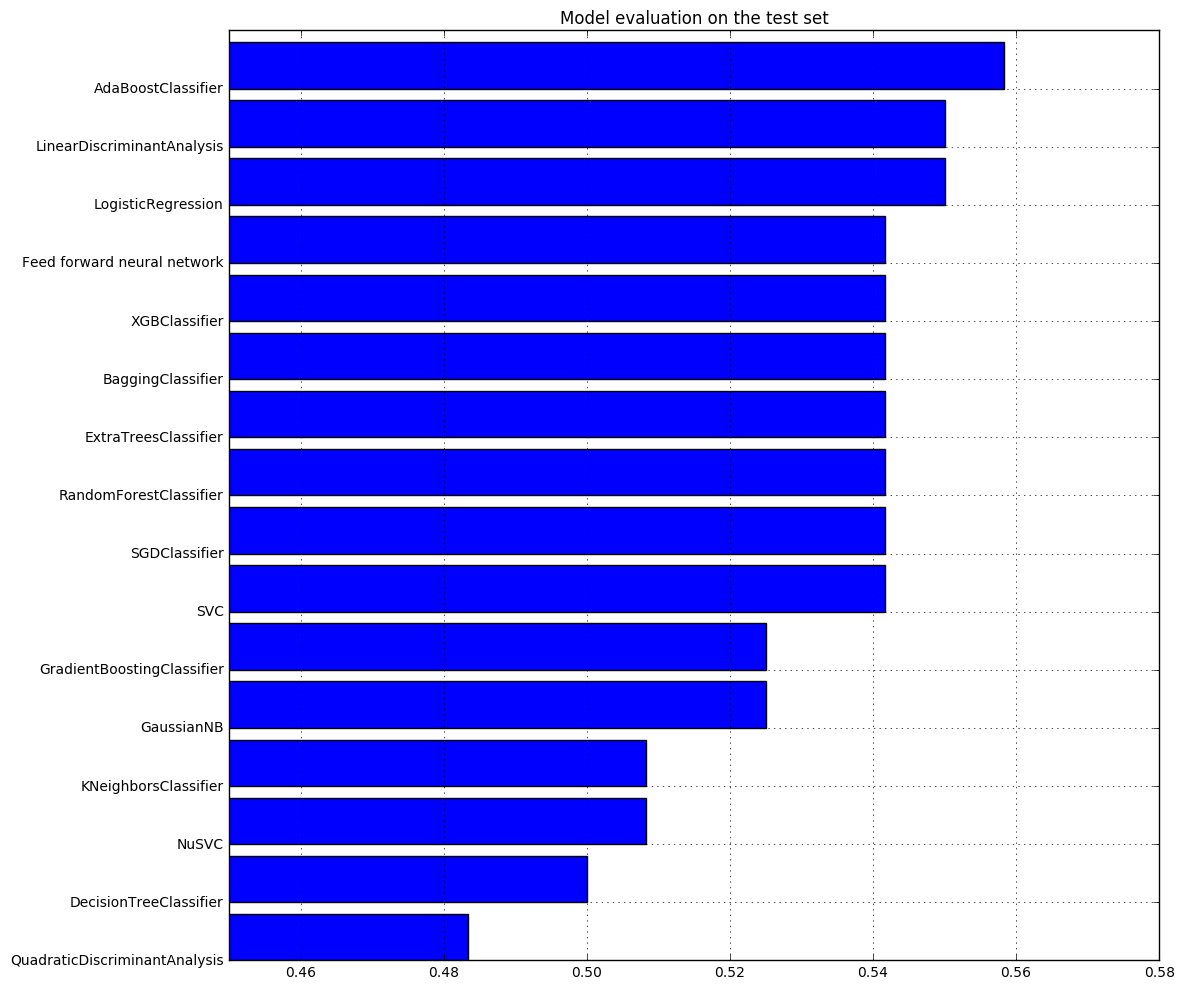

In [3]:
import matplotlib.pyplot as plt
fig=plt.figure (figsize=(12,12), facecolor='white')
plt.barh(range(0, len(classifier_scores)),zip(*classifier_scores)[1])
plt.yticks(range(0, len(classifier_scores)), zip(*classifier_scores)[0])
plt.xlim([0.45,0.58])
plt.grid()
plt.title('Model evaluation on the test set')
plt.show()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Each classification model was used to predict stock up/down on next day, which considered fundamental as well as technical features as input variables. I trained each model on the whole training set and reported the accuracy on the test set, as shown in the figure above. Of all the learning algorithms I applied, the AdaBoost classifier showed the best accuracy of around 0.56. AdaBoost is a boosting ensemble algorithm. It weights samples by how easy or difficult they are classified, leading to pay more or less attention to them in the construction of subsequent models. Linear Discriminant Analysis and Logistic Regression also gave better prediction accuracy on the test set, compared with other models. However, Quadratic Discriminant Analysis, Decision Tree Classifier and K Neighbors Classifier showed poor prediction power on the unseen test data. 
     


 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Conclusion  </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
This project is aimed to apply machine learning and training it on the past stock data in order to predict  the sign of the movement of tomorrow‘s stock price. The results indicated that an AdaBoost classifier slightly outperformed other approaches. However, the best accuracy of 56% on short-term stock prediction is unsatisfying. This gives me a strong indication that there is no sufficient information to be found in the data to perform short-term prediction. Some underlying factors that can dramatically influence the future stock movement are not in scope of this project, such as Election results, rumors, political Effects, upgraded/downgraded by analysts, investor sentiments, etc. A more sophisticated algorithm may be needed to quantify and take these factors into consideration in Machine learning system. Other technique may be able to be considered for improving stock prediction:  a hybrid algorithm made of several learning models. For example, a combination of artificial neural networks (ANN) with Decision Tree was already reported to improve prediction accuracy of ANN.  
<br\>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
I am glad that I worked through the building procedures of Machine learning algorithms. I earned some knowledges and experience from it.  
 </span></div>